<h1>GLASSES OR NO GLASSES</h1>

The aim of this work is to determine if a person is wearing glasses or not, in a supervised way, using neural networks.<br>The data is available on <a href>https://www.kaggle.com/jeffheaton/glasses-or-no-glasses</a> , where there are two datasets of the same 5000 samples provided in two different configurations:
<ul>
  <li>samples made up of 512 numerical features (and 0-1 labels), which we will use to train a simple MLP.</li>
  <li>1024x1024 color images, which we will use to train a CNN.</li>
</ul>

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

from tensorflow.keras.metrics import Accuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

# hyperparameter tuning
from keras_tuner import RandomSearch

pd.set_option('display.float_format', lambda x: '%.5f' % x)

2021-09-13 10:06:22.426020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-13 10:06:22.426039: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from sklearn.metrics import plot_roc_curve

In [3]:
# in order to count the time spent executing the whole experiment
program_start_time = time.time()

We set the *random_state*, in order to allow reproducibility.

In [4]:
random_state = int(time.time())

os.environ['PYTHONHASHSEED'] = str(random_state)
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

random_state

1631520383

<h3>Numerical Dataset</h3>

<h5>Importing the data</h5>

Training and Test set are provided separately in *.csv* format. We have previously downloaded them, so now we can easily import them as Pandas dataframes and then we merge them. We will do some preprocessing and then create our personal splits.

In [5]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'

train_df = pd.read_csv(train_path).iloc[:, 1:]
test_df = pd.read_csv(test_path).iloc[:, 1:]

print(f'\nShapes:\nTraining set shape: {train_df.shape[0]}x{train_df.shape[1]}\nTest set shape:      {test_df.shape[0]}x{test_df.shape[1]}')


Shapes:
Training set shape: 4500x513
Test set shape:      500x513


In [6]:
# concatenate train and test dataframes
df = pd.concat([train_df, test_df], ignore_index=True)
df

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v504,v505,v506,v507,v508,v509,v510,v511,v512,glasses
0,0.37797,-0.94808,0.01346,0.17893,0.37795,0.63571,0.13943,-0.25607,-0.39341,1.08947,...,-0.03494,1.32443,-0.94570,0.02055,-1.23908,0.43507,1.08635,1.69027,0.61609,0.00000
1,0.07609,-0.09774,0.39666,-0.39026,0.10606,0.52774,0.07105,0.33720,0.69917,-0.02842,...,0.86624,-1.24953,-0.21511,-1.54146,1.04765,-1.24035,0.00866,-1.27640,-0.60496,1.00000
2,1.19391,-0.68707,-0.68422,-0.36378,-0.60847,-0.40118,1.45432,0.00592,1.68940,-0.98205,...,-0.35893,0.02330,0.31548,-0.34923,-0.41772,-0.58175,-0.60177,0.43555,0.41982,1.00000
3,1.34949,-0.31498,-1.30248,0.50278,1.66292,-1.06094,-0.70835,-0.24237,-0.15509,-0.04532,...,0.23942,0.20774,0.81792,-0.74814,-0.62521,0.01689,0.83997,-0.46986,0.06755,0.00000
4,-0.03512,-0.34196,0.14230,1.50513,-0.14364,0.49429,0.07823,-0.04356,0.42009,-0.88828,...,-1.78407,0.07465,1.50182,-0.41289,-0.55908,-0.29702,0.83641,0.59756,-0.20298,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.07877,-0.47999,0.26438,0.96854,-0.89655,-0.21550,-0.28405,0.27737,1.16353,-0.65644,...,-0.11268,-0.10283,1.29375,-0.35066,-0.20521,1.92194,-0.43146,0.26931,-0.84718,1.00000
4996,1.93614,0.55157,-1.50441,0.08463,-0.81710,0.20543,1.19491,0.06756,-0.12916,-0.06072,...,0.57310,0.17351,-0.28986,0.64548,-0.24547,-0.77679,0.02158,-0.48717,-0.34507,1.00000
4997,0.08998,-0.33035,0.15433,0.92103,-0.21762,-0.11923,1.02854,0.95636,-0.79264,1.15594,...,0.22510,-0.46113,-0.74823,0.18642,-1.06619,-0.61864,-1.32600,-0.16452,-0.20689,1.00000
4998,-1.00379,0.15693,0.25717,-0.78155,-0.35788,0.09297,1.59270,-0.76649,1.04933,-0.47709,...,-0.47794,0.21047,0.12610,-0.04271,0.54528,-0.25951,0.08115,1.23236,0.42304,0.00000


<h5>Undefined labels</h5>

In the original data there are no NaN values. However, while getting a look at the labels, we found out that some were wrong. While correcting them, we noticed some images in which stating if the person had glasses or not was hard: this happens because the subjects are not real people (they are created by a Generative Adversarial Neural Network), so there can be some errors. We decide to drop samples with undefined labels.

Example of image with a label that is hard to define


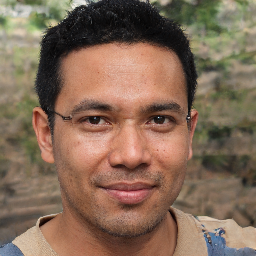

In [7]:
print('Example of image with a label that is hard to define')
load_img('images/face-411.png', target_size=(256, 256))

In [8]:
# delete rows with NaN values
if df.isnull().values.any():
    print(f'{df.isnull().values.ravel().sum()} row(s) with undefined labels in the set have been found and will be removed.')    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

print(f'New shape:\nTraining set:  {df.shape}')

21 row(s) with undefined labels in the set have been found and will be removed.
New shape:
Training set:  (4979, 513)


<h5>Balancing</h5>

Now we look at the balancing between labels, in order to decide if we should go for some under/oversampling.<br>Fortunately, the dataset is pretty well balanced, so we don't need to apply any sort of rebalancing.

2784 Glasses
2195 No Glasses


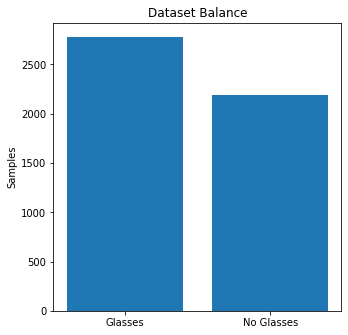

In [9]:
ones, zeros = df['glasses'].value_counts()
print(f'{ones} Glasses\n{zeros} No Glasses')

x_labels, x_values = ['Glasses', 'No Glasses'], [ones, zeros]
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Samples')
ax.set_yticks(np.arange(0, df.shape[0], 500))
ax.bar(x_labels, x_values)
plt.title('Dataset Balance')
plt.show()

<h5>Standardization</h5>

After separating the labels from the data, we apply standardization to the latter: remembering that columns are features and rows are sample, we compute the mean and standard deviation of every feature, then we take each element of a sample, we subtract the corresponding mean from it and then we divide the result by the corresponding standard deviation. In this way, every feature will have a mean of 0 and a standard deviation of 1.

In [10]:
X = df.iloc[:, :-1].to_numpy()
Y = np.array(df['glasses'], dtype=float)

In [11]:
X = df.iloc[:, :-1]
means = X.mean()
stds = X.std()
X = np.apply_along_axis(lambda x:(x-means)/stds, 1, X.to_numpy())

pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,...,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000,4979.00000
mean,-0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,...,0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000
std,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
min,-3.79274,-3.11129,-3.40121,-3.66188,-2.95796,-5.17255,-3.60413,-3.71636,-3.28843,-3.81335,...,-3.36658,-3.67980,-3.62999,-3.76251,-3.85986,-4.20086,-3.23597,-3.29227,-3.67995,-3.42457
25%,-0.67636,-0.67435,-0.68575,-0.69029,-0.70579,-0.66968,-0.69089,-0.64209,-0.69865,-0.70021,...,-0.69396,-0.61000,-0.67715,-0.65671,-0.67987,-0.64228,-0.70748,-0.67577,-0.64214,-0.66832
50%,-0.04036,-0.03543,0.01622,-0.04316,-0.00937,-0.01412,-0.00505,-0.00036,-0.01986,-0.00793,...,0.00552,-0.04772,-0.02735,0.01825,-0.02894,-0.01004,-0.02843,-0.00238,0.02120,-0.02354
75%,0.61934,0.64729,0.69587,0.67204,0.70427,0.68690,0.66882,0.64051,0.68290,0.70087,...,0.67378,0.62336,0.68117,0.68885,0.67129,0.66385,0.67534,0.69934,0.66669,0.65020
max,3.22772,3.40899,4.97356,3.77388,4.15482,3.96861,3.62347,4.00404,3.37165,3.32450,...,3.65096,4.14593,3.14954,3.70707,4.33943,3.63157,3.92717,3.54017,3.13389,3.48118


<h5>Data Visualization: Principal Component Analysis and t-Distributed Stochastic Neighbor Embedding</h5>

Next, we apply dimensionality reduction: in general, dimensionality reduction is tool to map a high-dimensional space into a low-dimensional space, hopefully keeping untouched the meaningful properties of the original data, and, at the same time, allowing to have a simplier look at them.
We decide to reduce dimensionality only for visualization (thus we will reduce the dimensions from 512 to 2), using two techniques:
<ul>
  <li>PCA, a linear transformation that aims to map dissimilar points into distant low-dimensional representation.</li>
  <li>t-SNE, that is non-linear and, in addition, tries to keep similar points closer in the low-dimensional representation. Being non-linear, it is harder to compute and, thus, leads to better results.</li>
</ul>


In [12]:
def pca_visualization(data:tuple, n_components:int, random_state=None):
    X, Y = data
    n_components = 2
    reduced_X = PCA(n_components=n_components, random_state=random_state).fit_transform(X)

    fig = plt.figure(figsize=(8,8))
    plt.title('PCA')
    colors = ListedColormap(['blue', 'orange'])
    scatter = plt.scatter(reduced_X[:, 0], reduced_X[:, 1], alpha=0.5, c=Y, cmap=colors)
    plt.legend(handles=scatter.legend_elements()[0], labels=['Glasses', 'No Glasses'])
    plt.show()
    
    return reduced_X

def tsne_visualization(data:tuple, n_components=2, perplexity=30, init='pca', random_state=None, method='barnes_hut', n_jobs=None):
    X, Y = data
    tsne_X = TSNE(n_components=n_components, perplexity=perplexity, init=init, random_state=random_state, method=method, n_jobs=n_jobs).fit_transform(X)

    fig = plt.figure(figsize=(8,8))
    plt.title('t-SNE')
    colors = ListedColormap(['blue', 'orange'])
    scatter = plt.scatter(tsne_X[:, 0], tsne_X[:, 1], alpha=0.5, c=Y, cmap=colors)
    plt.legend(handles=scatter.legend_elements()[0], labels=['Glasses', 'No Glasses'])
    plt.show()
    
    return tsne_X

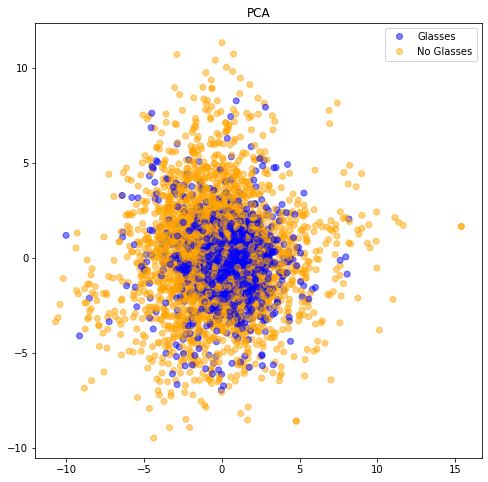

In [13]:
n_components = 2
reduced_X = pca_visualization((X, Y), n_components=n_components, random_state=random_state)

PCA doesn't show much: we can only see that samples corresponding to people with glasses are groupd around the center but, this representation suggests us that a linear transformation is not enough.

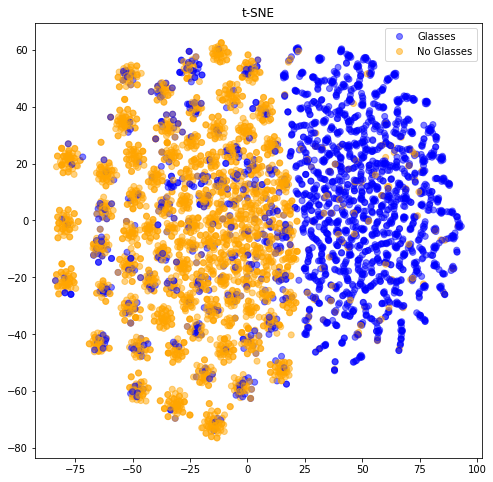

In [14]:
tsne_X = tsne_visualization((X, Y), n_components=n_components, random_state=random_state, n_jobs=-1)

t-SNE (thus, non-linearity) works definitely better: there is a clear line that separates the majority of positive and negative samples. This means that data and labels are indeed related and neural networks can help us to capture this relation.

<h3>Multi-Layer Perceptron</h3>

<h5>Train/Test split</h5>

The first thing we do now is a train/test split with a ratio of 0.8/0.2. We skip the creation of a validation set for the moment.

In [15]:
test_size = 0.2

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.175, random_state=random_state)

print(f'Training set:   {X_train_val.shape}')
print(f'Test set:        {X_test.shape}')
#print(f'Validation set:  {X_val.shape}')

Training set:   (3983, 512)
Test set:        (996, 512)


In [16]:
# This creates the folds as defined in k-fold cross validation
def k_fold(size:int, k:int) -> list:
    indices = np.array(range(size))
    np.random.shuffle(indices)
    folds = []
    splits = np.array_split(indices, k, axis=0)
    for i in range(k):
        folds.append((np.delete(indices, splits[i]), splits[i]))
    return folds


# This creates a model given a list of layers and some other hyperparameters
def build_model(layers:list, optimizer, learning_rate, loss, metrics):
    model = Sequential()    
    for l in layers:
        model.add(l)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss=loss, metrics=metrics)  
    return model


# This allows to plot accuracy and loss for every trained model
def plot_results(metrics:(), metric_name:str):
    plt.plot(metrics[0])
    plt.plot(metrics[1])
    plt.title('Model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
# This prints the various scores of a model
def print_results(loss, accuracy, val_loss, val_accuracy, test_loss, test_accuracy):
    print(f'\nTraining Loss:        {loss}')
    print(f'Training Accuracy:    {accuracy}')
    print(f'\nValidation Loss:      {val_loss}')
    print(f'Validation Accuracy:  {val_accuracy}')
    print(f'\nTest Loss:            {test_loss}')
    print(f'Test Accuracy:        {test_accuracy}')    

<h5>A first simple model</h5>

We are facing a binary classification problem. Thus, we use *sigmoid* as function for our output neuron and *binary crossentropy* as loss function.<br>
We try a simple model with just one hidden layer of 16 neurons with *relu* activation function, a *batch size* of 128 and 20 *epochs*, with an *early stopping* if the *validation loss* stops to decrease. We use *Adam* with a *learning rate* of 0.001 as *optimizer*.

In [17]:
# training parameters
epochs = 50
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

num_features = X_train_val.shape[1]

In [18]:
# hyperparameters to create he model
optimizer, learning_rate = Adam, 1e-3
loss = binary_crossentropy
metrics = ['accuracy', TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()]

layers = [Dense(16, activation='relu', input_shape=(num_features,)),
          Dense(8, activation='relu')]

model = build_model(layers, optimizer, learning_rate, loss, metrics)

start_time = time.time()
history = model.fit(x=X_train_val, y=Y_train_val, epochs=epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.2, verbose=0, callbacks=[early_stopping])
print(f'{round(time.time() - start_time, 2)} seconds spent training')

2021-09-13 10:06:57.209830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-13 10:06:57.209868: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-13 10:06:57.209886: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (flavio-ubuntu): /proc/driver/nvidia/version does not exist
2021-09-13 10:06:57.210120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-13 10:06:57.301371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR 

1.8 seconds spent training


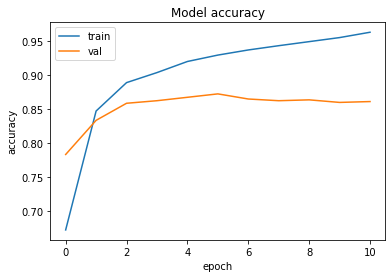

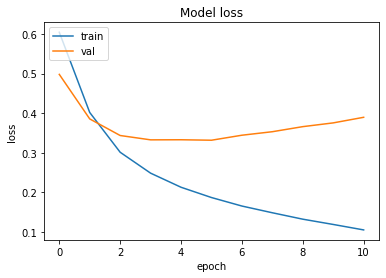


Training Loss:        0.105278879404068
Training Accuracy:    0.9626491069793701

Validation Loss:      0.3896462917327881
Validation Accuracy:  0.8607277274131775

Test Loss:            0.28862473368644714
Test Accuracy:        0.8965863585472107


In [19]:
plot_results((history.history['accuracy'], history.history['val_accuracy']), 'accuracy')
plot_results((history.history['loss'], history.history['val_loss']), 'loss')

test_loss, test_accuracy, test_tp, test_tn, test_fp, test_fn= model.evaluate(X_test, Y_test, batch_size, verbose=0)

print_results(history.history['loss'][-1], history.history['accuracy'][-1], history.history['val_loss'][-1],
              history.history['val_accuracy'][-1], test_loss, test_accuracy)

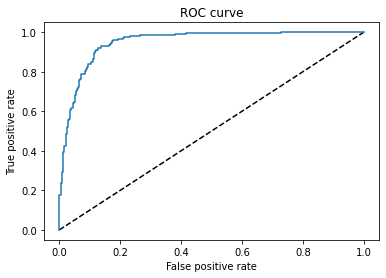

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Y_pred = model.predict(X_test).ravel()
test_fpr, test_tpr, thresholds = roc_curve(Y_test, Y_pred)
auc = auc(test_fpr, test_tpr)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(test_fpr, test_tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

The discrepancy between training and validation/test accuracy and the shape of the two curves suggest us that our predictor clearly suffers from overfitting.

<h5>Second model (with Dropout)</h5>

Adding units or making the network deeper would make the network overfit even more; thus, we can try to apply *dropout* to reduce the number of parameters.

In [23]:
layers = [Dense(16, activation='relu', input_shape=(num_features,)),
          Dropout(0.4),
          Dense(8, activation='relu')]
metrics=['accuracy']

model = build_model(layers, optimizer, learning_rate, binary_crossentropy, metrics)

start_time = time.time()
history = model.fit(x=X_train_val, y=Y_train_val, epochs=epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.2, verbose=0, callbacks=[early_stopping])
print(f'{round(time.time() - start_time, 2)} seconds spent training')

1.06 seconds spent training


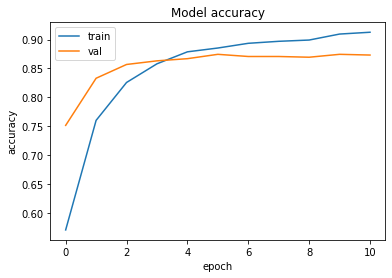

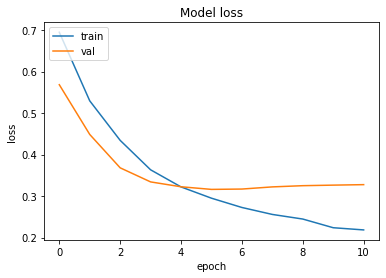


Training Loss:        0.21853294968605042
Training Accuracy:    0.9127432703971863

Validation Loss:      0.3276364803314209
Validation Accuracy:  0.8732748031616211

Test Loss:            0.27265340089797974
Test Accuracy:        0.9066265225410461


In [24]:
plot_results((history.history['accuracy'], history.history['val_accuracy']), 'accuracy')
plot_results((history.history['loss'], history.history['val_loss']), 'loss')

test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size, verbose=0)

print_results(history.history['loss'][-1], history.history['accuracy'][-1], history.history['val_loss'][-1],
              history.history['val_accuracy'][-1], test_loss, test_accuracy)

We reduced the overfitting in some way, but the predictor doesn't perform much better.

<h5>Third model (with regularizers and more neurons)</h5>

We can try another model with an increased number of units but with a greater percentage of dropout and the addition of regularizers, that fight overfitting penalizing the parameters of the network.

In [25]:
layers = [Dense(128, activation='relu', input_shape=(num_features,), kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
          Dropout(0.4),
          Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
          Dropout(0.4),
          Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))]

model = build_model(layers, optimizer, learning_rate, binary_crossentropy, metrics)

start_time = time.time()
history = model.fit(x=X_train_val, y=Y_train_val, epochs=epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.2, verbose=0, callbacks=[early_stopping])
print(f'{round(time.time() - start_time, 2)} seconds spent training')

4.13 seconds spent training


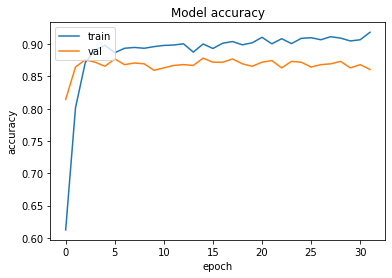

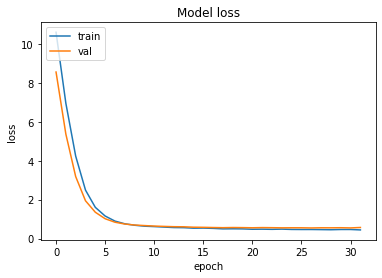


Training Loss:        0.44175076484680176
Training Accuracy:    0.9183929562568665

Validation Loss:      0.5665906667709351
Validation Accuracy:  0.8607277274131775

Test Loss:            0.5032743215560913
Test Accuracy:        0.8945783376693726


In [26]:
plot_results((history.history['accuracy'], history.history['val_accuracy']), 'accuracy')
plot_results((history.history['loss'], history.history['val_loss']), 'loss')

test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size, verbose=0)

print_results(history.history['loss'][-1], history.history['accuracy'][-1], history.history['val_loss'][-1],
              history.history['val_accuracy'][-1], test_loss, test_accuracy)

Sadly, the results did not get much better.

<h5>RandomSearch</h5>

Wenow try 

In [27]:
def random_search_model(hp):
    min_layers, max_layers = 1, 10
    num_layers = range(hp.Int("num_layers", min_layers, max_layers))

    model = Sequential() 
    for i in num_layers:
        model.add(Dense(units=hp.Choice('units_'+str(i), values=[4, 8, 16, 32, 64, 128, 256]),
                        kernel_regularizer=regularizers.l1_l2(l1=hp.Choice('l1_'+str(i), values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4]),
                                                              l2=hp.Choice('l2_'+str(i), values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])),
                        activation=hp.Choice('activation_'+str(i), values=['relu', 'sigmoid', 'tanh'])))
        model.add(Dropout(rate=hp.Choice('rate_'+str(i), values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(Dense(1, activation='sigmoid'))    
    model.compile(Adam(1e-3), loss=binary_crossentropy, metrics=["accuracy"])
    
    return model

In [28]:
tuner = RandomSearch(random_search_model,
                     objective="val_accuracy",
                     max_trials=5, #3
                     executions_per_trial=5, #2
                     overwrite=True)

tuner.search(X_train_val, Y_train_val, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True,
             verbose=1)

Trial 5 Complete [00h 00m 46s]
val_accuracy: 0.5533249974250793

Best val_accuracy So Far: 0.873776662349701
Total elapsed time: 00h 03m 06s
INFO:tensorflow:Oracle triggered exit


<h5>Applying k-Fold Cross-Validation (on the best model according to RandomSearch)</h5>



1-th FOLD OUT OF 5

Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 1.8172 - accuracy: 0.6004 - val_loss: 1.1076 - val_accuracy: 0.7804
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 0.8298 - accuracy: 0.8478 - val_loss: 0.6256 - val_accuracy: 0.8733
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5828 - accuracy: 0.8773 - val_loss: 0.5239 - val_accuracy: 0.8708
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5125 - accuracy: 0.8933 - val_loss: 0.4824 - val_accuracy: 0.8770
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4936 - accuracy: 0.8898 - val_loss: 0.4659 - val_accuracy: 0.8846
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4706 - accuracy: 0.8955 - val_loss: 0.4716 - val_accuracy: 0.8595
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4636 - accuracy: 0.8952 - val_loss: 0.4442 - val_accuracy: 0.879

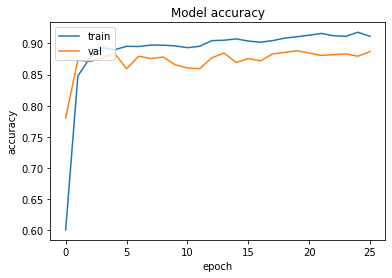

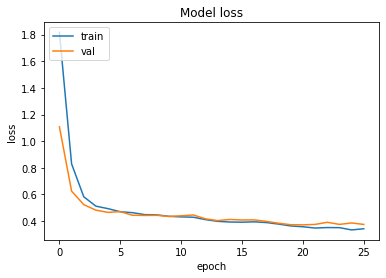



2-th FOLD OUT OF 5

Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 1.8301 - accuracy: 0.5904 - val_loss: 1.1241 - val_accuracy: 0.7892
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 0.8632 - accuracy: 0.8449 - val_loss: 0.6594 - val_accuracy: 0.9009
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5990 - accuracy: 0.8870 - val_loss: 0.5344 - val_accuracy: 0.9021
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5137 - accuracy: 0.9005 - val_loss: 0.4655 - val_accuracy: 0.9184
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4703 - accuracy: 0.9052 - val_loss: 0.4541 - val_accuracy: 0.9222
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4468 - accuracy: 0.9146 - val_loss: 0.4266 - val_accuracy: 0.9310
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4252 - accuracy: 0.9297 - val_loss: 0.4242 - val_accuracy: 0.915

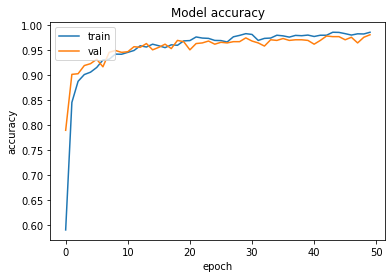

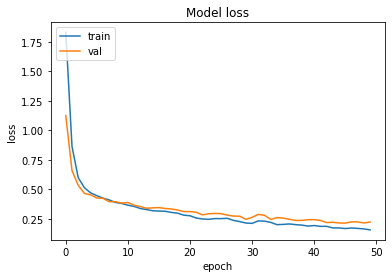



3-th FOLD OUT OF 5

Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 1.7273 - accuracy: 0.6099 - val_loss: 1.0539 - val_accuracy: 0.7629
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 0.7971 - accuracy: 0.8051 - val_loss: 0.6128 - val_accuracy: 0.8908
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5623 - accuracy: 0.8675 - val_loss: 0.5250 - val_accuracy: 0.8971
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5207 - accuracy: 0.8738 - val_loss: 0.5073 - val_accuracy: 0.9072
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5001 - accuracy: 0.8820 - val_loss: 0.4906 - val_accuracy: 0.8996
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4966 - accuracy: 0.8741 - val_loss: 0.4822 - val_accuracy: 0.9134
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4728 - accuracy: 0.8876 - val_loss: 0.4604 - val_accuracy: 0.913

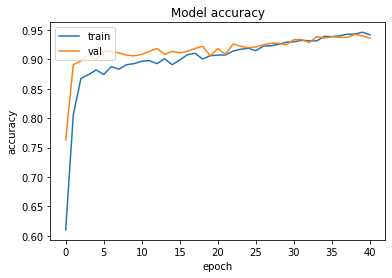

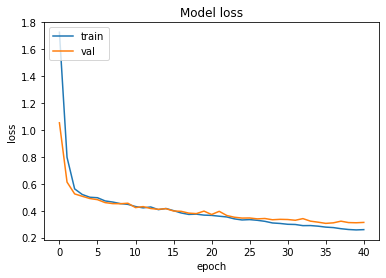



4-th FOLD OUT OF 5

Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 1.9222 - accuracy: 0.5827 - val_loss: 1.2640 - val_accuracy: 0.7073
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 0.9665 - accuracy: 0.8302 - val_loss: 0.7454 - val_accuracy: 0.8894
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.6450 - accuracy: 0.8939 - val_loss: 0.5584 - val_accuracy: 0.9033
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5105 - accuracy: 0.9008 - val_loss: 0.4755 - val_accuracy: 0.9196
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4341 - accuracy: 0.9118 - val_loss: 0.4039 - val_accuracy: 0.9033
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3617 - accuracy: 0.9150 - val_loss: 0.3452 - val_accuracy: 0.9108
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3225 - accuracy: 0.9234 - val_loss: 0.2980 - val_accuracy: 0.934

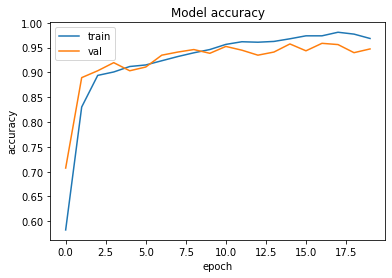

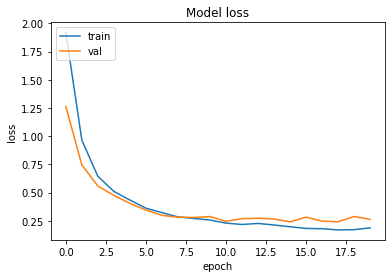



5-th FOLD OUT OF 5

Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 1.8310 - accuracy: 0.7302 - val_loss: 1.1117 - val_accuracy: 0.8693
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 0.8391 - accuracy: 0.8651 - val_loss: 0.6335 - val_accuracy: 0.8982
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5753 - accuracy: 0.8779 - val_loss: 0.5064 - val_accuracy: 0.9070
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4964 - accuracy: 0.8870 - val_loss: 0.4626 - val_accuracy: 0.9070
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4614 - accuracy: 0.8892 - val_loss: 0.4235 - val_accuracy: 0.9070
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4341 - accuracy: 0.8826 - val_loss: 0.3984 - val_accuracy: 0.9158
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4094 - accuracy: 0.8896 - val_loss: 0.3859 - val_accuracy: 0.908

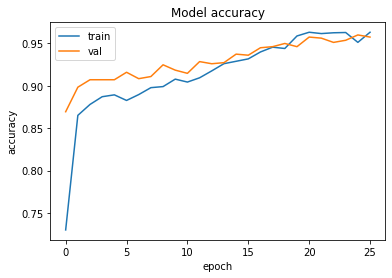

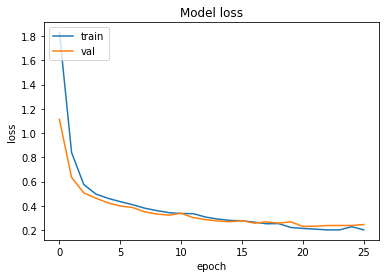

22.24 seconds spent training

Avg Training Loss:        0.22956
Avg Training Accuracy:    0.95386

Avg Validation Loss:      0.28407
Avg Validation Accuracy:  0.94151

Avg Test Loss:            0.49857
Avg Test Accuracy:        0.8743


In [29]:
k = 5
plot = 1
folds_results = {'accuracy':[], 'val_accuracy':[], 'test_accuracy':[], 'loss':[], 'val_loss':[], 'test_loss':[]}

best_model = tuner.get_best_models()[0]

start_time = time.time()
for j, fold in enumerate(k_fold(X_train_val.shape[0], k)):
    
    X_train, X_val = X_train_val[fold[0]], X_train_val[fold[1]]
    Y_train, Y_val = Y_train_val[fold[0]], Y_train_val[fold[1]]
    
    print(f'\n\n{j+1}-th FOLD OUT OF {k}\n')
    model = tf.keras.models.clone_model(best_model)
    model.compile(optimizer=Adam(1e-3), loss=binary_crossentropy, metrics=['accuracy'])
    history = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True,
                                  validation_data=(X_val, Y_val), verbose=1, callbacks=[early_stopping])   

    # saving results for a single fold
    folds_results['accuracy'].append(history.history['accuracy'][-1])
    folds_results['val_accuracy'].append(history.history['val_accuracy'][-1])
    folds_results['loss'].append(history.history['loss'][-1])
    folds_results['val_loss'].append(history.history['val_loss'][-1])

    test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
    folds_results['test_accuracy'].append(test_accuracy)
    folds_results['test_loss'].append(test_loss)


    # plotting accuracy and loss for training and validation set for a single fold
    if plot:
        plot_results((history.history['accuracy'], history.history['val_accuracy']), 'accuracy')
        plot_results((history.history['loss'], history.history['val_loss']), 'loss')

print(f'{round(time.time() - start_time, 2)} seconds spent training')
    
print(f"\nAvg Training Loss:        {round(sum(folds_results['loss'])/k, 5)}")
print(f"Avg Training Accuracy:    {round(sum(folds_results['accuracy'])/k, 5)}")
print(f"\nAvg Validation Loss:      {round(sum(folds_results['val_loss'])/k, 5)}")
print(f"Avg Validation Accuracy:  {round(sum(folds_results['val_accuracy'])/k, 5)}")
print(f"\nAvg Test Loss:            {round(sum(folds_results['test_loss'])/k, 5)}")
print(f"Avg Test Accuracy:        {round(sum(folds_results['test_accuracy'])/k, 5)}")

Even when dealing with different couples of training/validation sets, the predictor performs as expected. We think that there is no great room for improvements; thus, we move to images, with the idea that they will lead to definitely better results.

<h3>Images</h3>

As already said, this dataset is made up of *1024x1024* RGB images of (not real) people wearing or not wearing glasses.

Example of person wearing glasses.


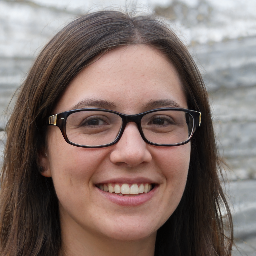

In [30]:
print('Example of person wearing glasses.')
load_img('images/face-15.png', target_size=(256, 256))

Example of person not wearing glasses.


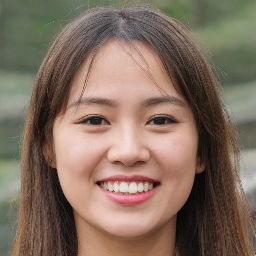

In [31]:
print('Example of person not wearing glasses.')
load_img('images/face-13.png', target_size=(256, 256))

<h5>Importing the data</h5>

We have previously downloaded all the images and placed them in the "*images*" folder. We import them using *load_img*, a function provided in *tf.keras.preprocessing.image* module. For matter of space and time complexity, we fix the size of images to be *128x128*, because a larger size would lead to slower computation without assuring the same increase of predicting performance.

In [32]:
imgs_num = 5000
height, width = 128, 128

already_downloaded = True

if not already_downloaded:
    imgs_matrices = np.empty(shape=(imgs_num), dtype=np.ndarray)

    start_time = time.time()
    for i in range(imgs_num):
        path = 'images/face-' + str(i+1) + '.png'
        img = load_img(path, target_size=(height, width))
        img_array = img_to_array(img)
        imgs_matrices[i] = img_array
    print(f'{round(time.time() - start_time, 2)} seconds spent importing images')

    X = np.array(imgs_matrices.tolist())
    Y = np.array(pd.concat([train_df, test_df], ignore_index=True)['glasses'], dtype=float)

    nans = []
    for index, y in enumerate(Y):
        if y!=1 and y!=0:
            nans.append(index)

    X = np.delete(X, nans, axis=0)
    Y = np.delete(Y, nans)

    np.save('images_array', X)
    np.save('labels_array', Y)
    
else:
    X = np.load('images_array.npy')
    Y = np.load('labels_array.npy')

Of course, we turn every image to a Numpy array and use the same array of labels we used for numerical data, dropping samples with undefined labels.<br>
In order to have values ranging from 0 to 1, we normalize each value of each sample, dividing it by *255*. 

In [33]:
# normalization
X = X / 255.0

In the end, we have a Numpy Array of 4979 images with *16384* pixels, each one being a vector of 3 elements, because we are dealing with color images.

In [34]:
X.shape

(4979, 128, 128, 3)

<h3>Convolutional Neural Network</h3>

<h5>Train/Test split</h5>

As we did before, we proceed with a 0.8/0.2 train/test split.

In [35]:
test_size = 0.2

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.175, random_state=random_state)

print(f'Training set:   {X_train_val.shape}')
print(f'Test set:        {X_test.shape}')
#print(f'Validation set:  {X_val.shape}')

Training set:   (3983, 128, 128, 3)
Test set:        (996, 128, 128, 3)


<h5>Training the Model</h5>

In [36]:
# training parameters
epochs = 10
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# hyperparameters
optimizer, learning_rate = Adam, 1e-3
loss = binary_crossentropy
metrics = ['accuracy']

In [37]:
# architecture
layers = [Conv2D(kernel_size=3, filters=8, activation='relu', input_shape=(height, width, 3)),
          MaxPooling2D(strides=2),
          Conv2D(kernel_size=5, filters=16, activation='relu'),
          MaxPooling2D(strides=2),
          Flatten(),
          Dense(32, activation='relu'),
          Dense(16, activation='relu')]

In [38]:
# building the model and training it
model = build_model(layers, optimizer, learning_rate, loss, metrics)

start_time = time.time()
history = model.fit(x=X_train_val, y=Y_train_val, epochs=epochs, batch_size=batch_size, shuffle=False,
                    validation_split=0.2, verbose=1, callbacks=[early_stopping])
print(f'{round(time.time() - start_time, 2)} seconds spent training')

Epoch 1/10
50/50 [==============================] - 15s 287ms/step - loss: 0.6602 - accuracy: 0.5876 - val_loss: 0.5472 - val_accuracy: 0.8444
Epoch 2/10
50/50 [==============================] - 12s 239ms/step - loss: 0.2538 - accuracy: 0.9149 - val_loss: 0.0661 - val_accuracy: 0.9900
Epoch 3/10
50/50 [==============================] - 12s 246ms/step - loss: 0.0609 - accuracy: 0.9834 - val_loss: 0.0596 - val_accuracy: 0.9737
Epoch 4/10
50/50 [==============================] - 13s 253ms/step - loss: 0.0408 - accuracy: 0.9887 - val_loss: 0.0243 - val_accuracy: 0.9937
Epoch 5/10
50/50 [==============================] - 15s 303ms/step - loss: 0.0300 - accuracy: 0.9937 - val_loss: 0.0170 - val_accuracy: 0.9962
Epoch 6/10
50/50 [==============================] - 15s 308ms/step - loss: 0.0281 - accuracy: 0.9947 - val_loss: 0.0140 - val_accuracy: 0.9962
Epoch 7/10
50/50 [==============================] - 15s 310ms/step - loss: 0.0283 - accuracy: 0.9947 - val_loss: 0.0120 - val_accuracy: 0.9975

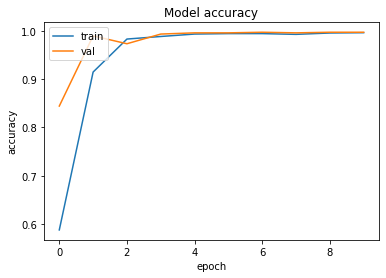

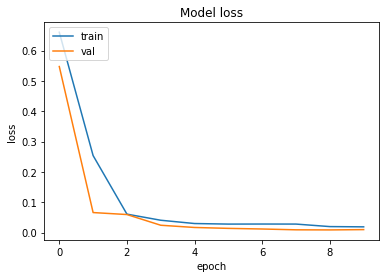


Training Loss:        0.019036604091525078
Training Accuracy:    0.9965474009513855

Validation Loss:      0.00993634108453989
Validation Accuracy:  0.9974905848503113

Test Loss:            0.020932301878929138
Test Accuracy:        0.9949799180030823


In [39]:
# plotting accuracy and loss
plot_results((history.history['accuracy'], history.history['val_accuracy']), 'accuracy')
plot_results((history.history['loss'], history.history['val_loss']), 'loss')

test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size, verbose=0)

print_results(history.history['loss'][-1], history.history['accuracy'][-1], history.history['val_loss'][-1],
              history.history['val_accuracy'][-1], test_loss, test_accuracy)

<h5>Applying k-Fold Cross-Validation</h5>



1-th FOLD OUT OF 5

Epoch 1/10
50/50 [==============================] - 17s 328ms/step - loss: 0.0931 - accuracy: 0.9815 - val_loss: 0.0237 - val_accuracy: 0.9987
Epoch 2/10
50/50 [==============================] - 18s 362ms/step - loss: 0.0256 - accuracy: 0.9953 - val_loss: 0.0228 - val_accuracy: 0.9987
Epoch 3/10
50/50 [==============================] - 19s 383ms/step - loss: 0.0258 - accuracy: 0.9950 - val_loss: 0.0203 - val_accuracy: 0.9987
Epoch 4/10
50/50 [==============================] - 20s 409ms/step - loss: 0.0210 - accuracy: 0.9950 - val_loss: 0.0185 - val_accuracy: 0.9987
Epoch 5/10
50/50 [==============================] - 17s 337ms/step - loss: 0.0184 - accuracy: 0.9965 - val_loss: 0.0204 - val_accuracy: 0.9975
Epoch 6/10
50/50 [==============================] - 18s 367ms/step - loss: 0.0173 - accuracy: 0.9959 - val_loss: 0.0165 - val_accuracy: 0.9987
Epoch 7/10
50/50 [==============================] - 18s 365ms/step - loss: 0.0185 - accuracy: 0.9959 - val_loss: 0.0178 

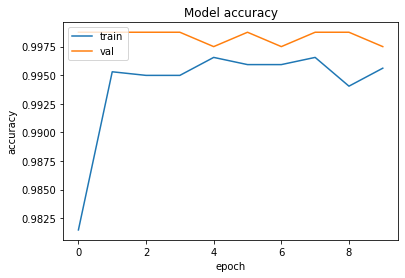

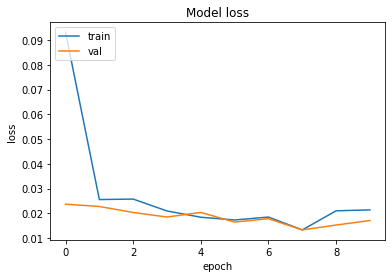




2-th FOLD OUT OF 5

Epoch 1/10
50/50 [==============================] - 17s 336ms/step - loss: 1.4330 - accuracy: 0.4749 - val_loss: 0.6524 - val_accuracy: 0.5734
Epoch 2/10
50/50 [==============================] - 18s 368ms/step - loss: 0.5662 - accuracy: 0.5543 - val_loss: 0.4328 - val_accuracy: 0.5734
Epoch 3/10
50/50 [==============================] - 18s 366ms/step - loss: 0.3047 - accuracy: 0.8550 - val_loss: 0.1072 - val_accuracy: 0.9598
Epoch 4/10
50/50 [==============================] - 18s 371ms/step - loss: 0.0663 - accuracy: 0.9799 - val_loss: 0.0229 - val_accuracy: 0.9950
Epoch 5/10
50/50 [==============================] - 18s 355ms/step - loss: 0.0293 - accuracy: 0.9931 - val_loss: 0.0120 - val_accuracy: 0.9987
Epoch 6/10
50/50 [==============================] - 18s 368ms/step - loss: 0.0241 - accuracy: 0.9959 - val_loss: 0.0168 - val_accuracy: 0.9962
Epoch 7/10
50/50 [==============================] - 18s 370ms/step - loss: 0.0179 - accuracy: 0.9959 - val_loss: 0.0070

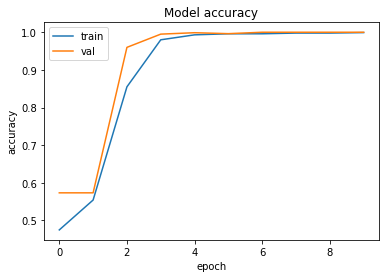

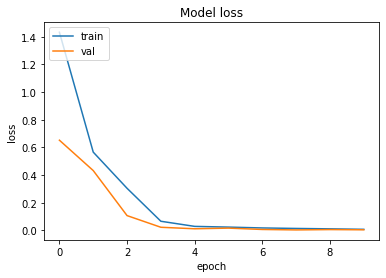




3-th FOLD OUT OF 5

Epoch 1/10
50/50 [==============================] - 16s 313ms/step - loss: 0.1281 - accuracy: 0.9576 - val_loss: 0.0157 - val_accuracy: 0.9987
Epoch 2/10
50/50 [==============================] - 13s 259ms/step - loss: 0.0143 - accuracy: 0.9975 - val_loss: 0.0136 - val_accuracy: 0.9987
Epoch 3/10
50/50 [==============================] - 17s 340ms/step - loss: 0.0124 - accuracy: 0.9981 - val_loss: 0.0108 - val_accuracy: 0.9962
Epoch 4/10
50/50 [==============================] - 15s 307ms/step - loss: 0.0100 - accuracy: 0.9987 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 15s 308ms/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 6/10
50/50 [==============================] - 16s 317ms/step - loss: 0.0060 - accuracy: 0.9994 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 16s 311ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0011

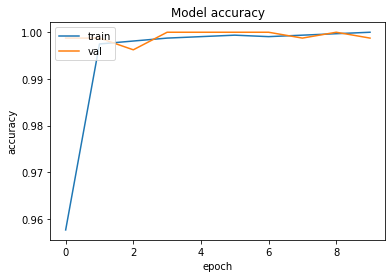

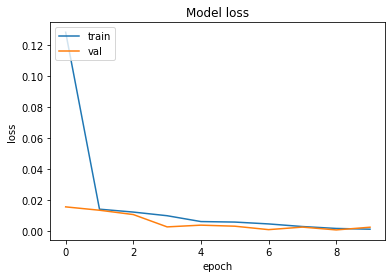




4-th FOLD OUT OF 5

Epoch 1/10
50/50 [==============================] - 16s 313ms/step - loss: 0.1680 - accuracy: 0.9523 - val_loss: 0.0141 - val_accuracy: 0.9962
Epoch 2/10
50/50 [==============================] - 17s 348ms/step - loss: 0.0136 - accuracy: 0.9975 - val_loss: 0.0054 - val_accuracy: 0.9975
Epoch 3/10
50/50 [==============================] - 17s 331ms/step - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 4/10
50/50 [==============================] - 18s 361ms/step - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 16s 318ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/10
50/50 [==============================] - 17s 340ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 18s 370ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0010

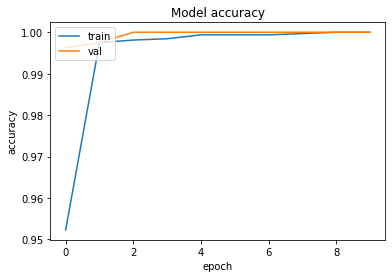

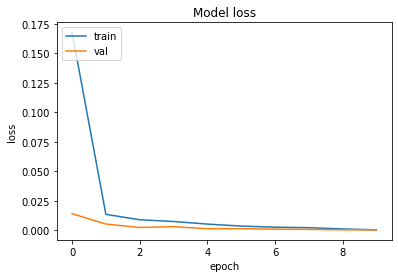




5-th FOLD OUT OF 5

Epoch 1/10
50/50 [==============================] - 14s 277ms/step - loss: 0.8631 - accuracy: 0.8001 - val_loss: 0.0521 - val_accuracy: 0.9887
Epoch 2/10
50/50 [==============================] - 13s 253ms/step - loss: 0.0285 - accuracy: 0.9928 - val_loss: 0.0251 - val_accuracy: 0.9899
Epoch 3/10
50/50 [==============================] - 14s 286ms/step - loss: 0.0115 - accuracy: 0.9975 - val_loss: 0.0078 - val_accuracy: 0.9987
Epoch 4/10
50/50 [==============================] - 14s 291ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 16s 327ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9987
Epoch 6/10
50/50 [==============================] - 14s 281ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 17s 341ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0046

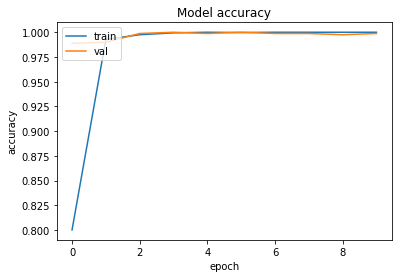

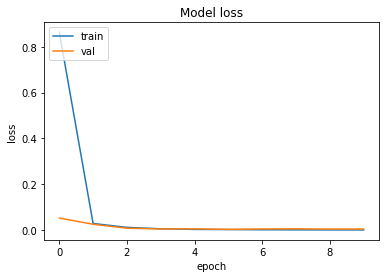


858.1 seconds spent training

Avg Training Loss:        0.00633
Avg Training Accuracy:    0.99893

Avg Validation Loss:      0.00579
Avg Validation Accuracy:  0.999

Avg Test Loss:            0.02546
Avg Test Accuracy:        0.99237


In [40]:
k = 5          # number of folds

plot = True    # if True, each fold will be plotted

folds_results = {'accuracy':[], 'val_accuracy':[], 'test_accuracy':[], 'loss':[], 'val_loss':[], 'test_loss':[]}

start_time = time.time()
for j, fold in enumerate(k_fold(X_train_val.shape[0], k)):      
    tf.keras.backend.clear_session()

    X_train, X_val = X_train_val[fold[0]], X_train_val[fold[1]]
    Y_train, Y_val = Y_train_val[fold[0]], Y_train_val[fold[1]]

    model = build_model(layers, optimizer, learning_rate, binary_crossentropy, metrics)
    
    print(f'\n\n{j+1}-th FOLD OUT OF {k}\n')
    history = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True,
                        validation_data=(X_val, Y_val), verbose=1, callbacks=[early_stopping])

    # saving results for a single fold
    folds_results['accuracy'].append(history.history['accuracy'][-1])
    folds_results['val_accuracy'].append(history.history['val_accuracy'][-1])
    folds_results['loss'].append(history.history['loss'][-1])
    folds_results['val_loss'].append(history.history['val_loss'][-1])

    test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
    folds_results['test_accuracy'].append(test_accuracy)
    folds_results['test_loss'].append(test_loss)

    # plotting accuracy and loss for training and validation set for a single fold
    if plot:
        plot_results((history.history['accuracy'], history.history['val_accuracy']), 'accuracy')
        plot_results((history.history['loss'], history.history['val_loss']), 'loss')
        print('')        
print(f'{round(time.time() - start_time, 2)} seconds spent training')

# avg results among all folds
print(f"\nAvg Training Loss:        {round(sum(folds_results['loss'])/k, 5)}")
print(f"Avg Training Accuracy:    {round(sum(folds_results['accuracy'])/k, 5)}")
print(f"\nAvg Validation Loss:      {round(sum(folds_results['val_loss'])/k, 5)}")
print(f"Avg Validation Accuracy:  {round(sum(folds_results['val_accuracy'])/k, 5)}")
print(f"\nAvg Test Loss:            {round(sum(folds_results['test_loss'])/k, 5)}")
print(f"Avg Test Accuracy:        {round(sum(folds_results['test_accuracy'])/k, 5)}")

As expected, images lead to great result.

In [41]:
print(f'{int(time.time() - program_start_time)} total seconds for the execution of the entire notebook')

1427 total seconds for the execution of the entire notebook
